# Using K-mean to calculate shop opening hours

## Introduction

In this notebook I show how to calculate opening hours of shops using a simple K-mean algorithm and anonymous pings of phones with time stamps. To calculate the opening hours, we will look at the distribution of the numbers of pings in bins of time (representing the number of people in the shop), as well as its derivative, the latter representing the rate of change with time. By doing this, we can use K-mean clustering to isolate some sudden changes in these quantities, and deduce the opening and closing hours of shops.

In [1]:
import numpy as np
import pandas as pd

# define the dataframe wit the data
df_data = pd.read_csv('./at_home_test_data_study_centers_201909.csv')

# list of the unique shops in the dataframe.
shop_id = np.unique(df_data['shopping_center_id'])

# Select a single shop to work with.
df_shop = df_data[df_data['shopping_center_id'] == shop_id[0]]
print(df_shop.head())
print('------------')
print(df_shop.info())
print('------------')
print('Minimum date: '+str(df_shop['device_local_date'].min()))
print('Maximum date: '+str(df_shop['device_local_date'].max()))

                      shopping_center_id    device_local_date device_hash_id
10  0cd35523-1eca-4f09-ab0d-0b506ae9d986  2019-09-13 18:58:23     9e19f26ae1
11  0cd35523-1eca-4f09-ab0d-0b506ae9d986  2019-09-13 16:15:44     e0d35598d7
22  0cd35523-1eca-4f09-ab0d-0b506ae9d986  2019-09-10 16:40:28     376887a798
28  0cd35523-1eca-4f09-ab0d-0b506ae9d986  2019-09-14 19:45:39     b79d5a0451
29  0cd35523-1eca-4f09-ab0d-0b506ae9d986  2019-09-14 10:12:15     f2a52cc4f5
------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11292 entries, 10 to 81837
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   shopping_center_id  11292 non-null  object
 1   device_local_date   11292 non-null  object
 2   device_hash_id      11292 non-null  object
dtypes: object(3)
memory usage: 352.9+ KB
None
------------
Minimum date: 2019-09-01 16:18:00
Maximum date: 2019-09-17 9:59:00


We only select one shop to work with (the first one in the list), and we note that, for this shop, we have 11292 non-null entries corresponding to the ID of the shopping center, the time stamp of the device's ping, and the ID of the device. The data roughly span 2 weeks, between the 1st and the 17th of September 2019.

To ease the analysis of the time data, we first define timestamps in Unix time and add it to the dataframe.

In [2]:
import datetime

# Convert the string time to timestamp (unix time [s])
device_local_date_timestamp = [datetime.datetime.timestamp(
    datetime.datetime.strptime(device_local_date_i, "%Y-%m-%d %H:%M:%S"))
                               for device_local_date_i in df_shop['device_local_date'].values]
df_shop = df_shop.assign(timestamp_unix = device_local_date_timestamp)
print(df_shop.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11292 entries, 10 to 81837
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shopping_center_id  11292 non-null  object 
 1   device_local_date   11292 non-null  object 
 2   device_hash_id      11292 non-null  object 
 3   timestamp_unix      11292 non-null  float64
dtypes: float64(1), object(3)
memory usage: 441.1+ KB
None


We further define a function which allows us to cut the time series, starting from a date and of length a number of full days, as specified by the user. The function returns a windowed dataframe.

In [3]:
def cut_time_series(t_s, start_date_time, l_in_days):
    ### cut the time series t_s to a time series starting from start_date_time and of length l_in_days ###
    
    # use the unix time to cut define the time.
    start_unix = datetime.datetime.timestamp(datetime.datetime.strptime(start_date_time, "%Y-%m-%d %H:%M:%S"))
    finish_unix = start_unix + 86400 * l_in_days
    
    t_s = t_s.sort_values('timestamp_unix')

    t_s_cut = t_s[t_s['timestamp_unix'].between(start_unix, finish_unix)]

    # return the cut dataframe of the time series.
    return t_s_cut


## Occupancy

To visualise the occupancy of the shop, we plot the number of pings per bins of 5 mins between two dates. Because we have 15 full days within our data, we cut the time series between the 02/09/2019 00:00:01 and the 16/09/2019 23:59:59, which corresponds to the 15 full days, and visualise the distribution of pings between these two dates. To further remove the noise, we smooth this distribution using a Gaussian kernel of width of 60 mins.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10697 entries, 957 to 15119
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shopping_center_id  10697 non-null  object 
 1   device_local_date   10697 non-null  object 
 2   device_hash_id      10697 non-null  object 
 3   timestamp_unix      10697 non-null  float64
dtypes: float64(1), object(3)
memory usage: 417.9+ KB
None


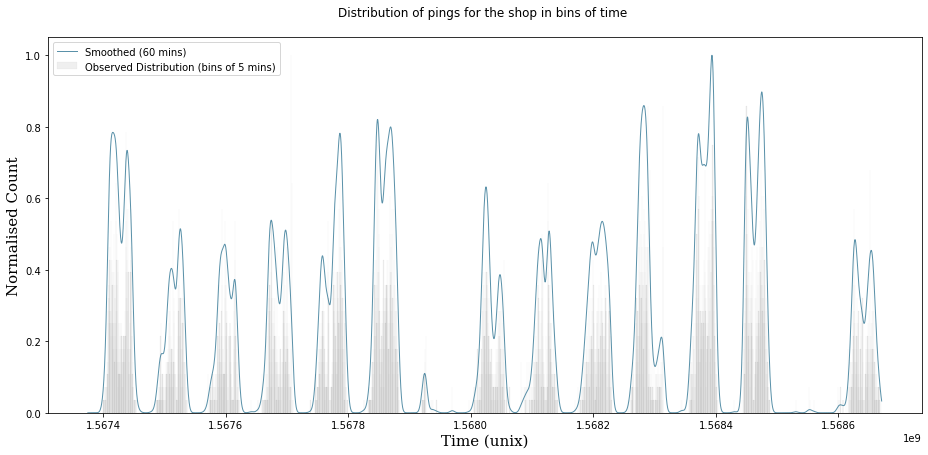

In [4]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font0 = FontProperties(family = 'serif', variant = 'small-caps', size = 15)

def Gauss(x, mu, sigma):
    ### Gaussian probability density function ###
    pdf = 1./sigma/np.sqrt(2.*3.14) * np.exp(-(x-mu)**2./2./sigma**2.)
    return pdf

# Data span from 01/09/2019 at ~16:00 to 17/09/2019 at 10:00
# We have 15 full days, so we will use these to construct the model.
t_s = cut_time_series(df_shop, '2019-09-02 00:00:01', 15)
print(t_s.info())

# Define bins of 5 mins between the two dates.
bin_start = datetime.datetime.fromtimestamp(t_s['timestamp_unix'].values.min()).replace(hour = 0, minute = 0, second = 0)
bin_end = datetime.datetime.fromtimestamp(t_s['timestamp_unix'].values.max()).replace(hour = 23, minute = 59, second = 59)
bins = np.arange(datetime.datetime.timestamp(bin_start), datetime.datetime.timestamp(bin_end), 300)

# Calculate the (normalised) occupancy in each of the bins
occup, bins = np.histogram(t_s['timestamp_unix'].values, bins = bins)
dx = (bins[1:] - bins[0:-1])/2.
bins = bins[0:-1] +dx
occup = occup/occup.max()

# Define a smoothing window using a Gaussian of width 60 mins
s_w = Gauss(bins, (datetime.datetime.timestamp(bin_start) + datetime.datetime.timestamp(bin_end))/2., 3600)

# Convolve the histogram with the smoothing window
smooth_occup = np.convolve(occup, s_w, mode = 'same')

# Interpolate and normalise the smoothed occupancy every 5 mins
x_smooth = np.arange(bins.min(), bins.max(), 300)
y_smooth = np.interp(x_smooth, bins, smooth_occup)
y_smooth /= y_smooth.max()

# Plot the results.
fig, axs = plt.subplots(figsize = (13, 6))
axs.bar(bins, occup, edgecolor = 'k', linewidth = 0.1, alpha = 0.2, label = 'Observed Distribution (bins of 5 mins)', color = '#b0b0b0', width = dx)
axs.plot(x_smooth, y_smooth, '-', lw = 1, alpha = 0.8, color = '#317694', label = 'Smoothed (60 mins)')
axs.set_ylabel('Normalised Count', fontproperties = font0)
axs.set_xlabel('Time (unix)', fontproperties = font0)
axs.legend()
plt.tight_layout()
plt.title('Distribution of pings for the shop in bins of time \n')
plt.show()

In this figure the greyed histogram is the observed occupancy (i.e. how many pings in each of the 5 mins bins), and the blue line shows the smoothed histogram using a Gaussian kernel of width of 60 mins. The broad peaks correspond to a day of the week, starting from Monday on the left-hand side of the graph, and finishing on a Monday 2 weeks later. The occupancy of the shop is different from one day to another. Even for the same day the occupancy changes from one week to another (see the three mondays in the figure above). This makes it difficult to extract the opening hours of the shop from the occupancy alone.

## Occupancy rate of change

One key aspect is how fast the occupancy is changing with time. One would expect that when the shop is close, only a minimum amount of staff will be around, creating little changes in the occupancy of the shop. Once the shop open, a large number of customer is expected to arrive, and the occupancy should increase dramatically. To test this, we calculate the first derivative of the smoothed occupancy with respect to time.

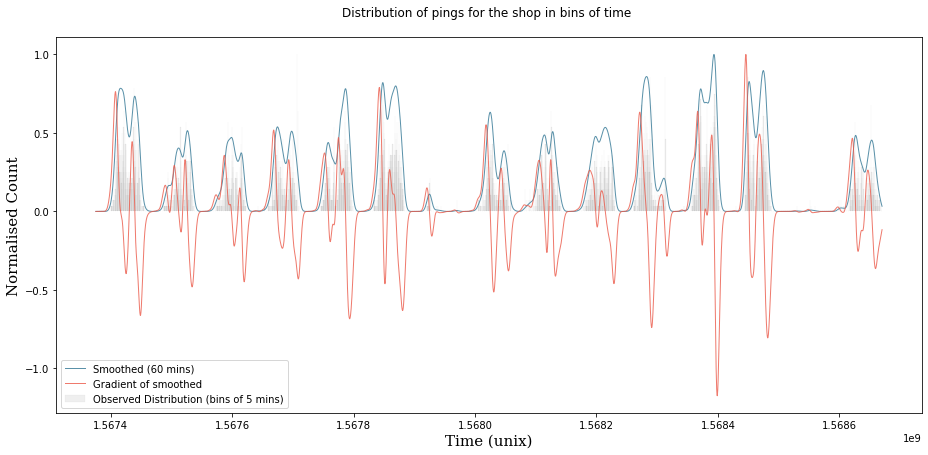

In [5]:
# Calculate the gradient and normalise it
dy_smooth = np.gradient(y_smooth)

# Overplot the result
fig, axs = plt.subplots(figsize = (13, 6))
axs.bar(bins, occup, edgecolor = 'k', linewidth = 0.1, alpha = 0.2, label = 'Observed Distribution (bins of 5 mins)', color = '#b0b0b0', width = dx)
axs.plot(x_smooth, y_smooth, '-', lw = 1, alpha = 0.8, color = '#317694', label = 'Smoothed (60 mins)')
axs.plot(x_smooth, dy_smooth/dy_smooth.max(), '-', lw = 1, alpha = 0.8, color = '#eb5949', label = 'Gradient of smoothed')
axs.set_ylabel('Normalised Count', fontproperties = font0)
axs.set_xlabel('Time (unix)', fontproperties = font0)
axs.legend()
plt.tight_layout()
plt.title('Distribution of pings for the shop in bins of time \n')
plt.show()

This figure shows the same as above, but with the added rate of change of occupancy (orange line). Positive and negative gradients indicate an increase and decrease in the number of pings, respectively. Large values (positive or negative) indicate a significant change in the occupancy of the shop, and are expected at opening and closing times. Therefore, by combining the absolute number of occupants, with its rate of change, we should be able to extract the opening hours of the shop.

## Calculating the opening hours of the shop

### The parameter space

We can now combine the occupancy of the shop and its rate of change in a single parameter space. To do this, we create a new dataframe which contains this two parameters at each of the time steps.

In [6]:
# We define a dataframe containing the variables that we will use to fit the model for the 
# opening hours of the shop
df_var = pd.DataFrame({'timestamp_unix': x_smooth,
                       'n_people': y_smooth, 
                       'dn_people': dy_smooth})
print(df_var.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4318 entries, 0 to 4317
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp_unix  4318 non-null   float64
 1   n_people        4318 non-null   float64
 2   dn_people       4318 non-null   float64
dtypes: float64(3)
memory usage: 101.3 KB
None


In this new dataframe, we have 4318 time steps covering 15 days with n_people and dn_people the occupancy of the shop and its rate of change respectively.

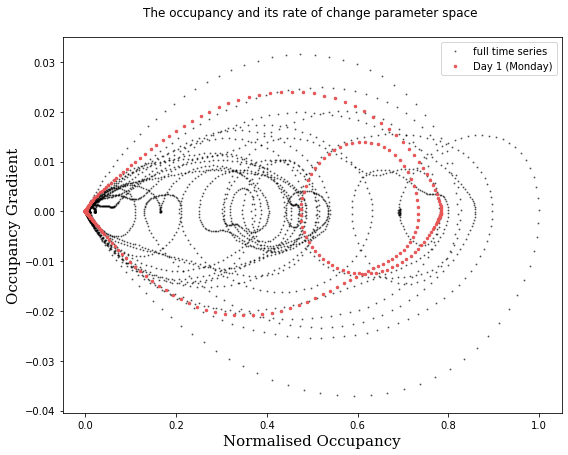

In [7]:
fig, axs = plt.subplots(figsize = (8, 6))
axs.plot(df_var['n_people'], df_var['dn_people'], 'k.', alpha = 0.5, ms = 2, label = 'full time series')
axs.plot(df_var['n_people'][0:300], df_var['dn_people'][0:300], '.', color = '#e85656', alpha = 1, ms = 5, label = 'Day 1 (Monday)')
axs.set_xlabel('Normalised Occupancy', fontproperties = font0)
axs.set_ylabel('Occupancy Gradient', fontproperties = font0)
axs.legend()
plt.tight_layout()
plt.title('The occupancy and its rate of change parameter space \n')
plt.show()

This figure shows how the Occupancy and its gradient change with time. Starting at zero in both parameters (shop is close and no phones are pinged), the occupancy (x-axis) increases as people arrive and decreases as people leave. If the gradient of occupancy changes (y-axis), it means that more people have arrived (left) at time t+1 than at time t. In other words, if at 9am two people arrive and at 10 am two other people arrive, the occupancy will have changed between 9am and 10 am (from two to four people), but the gradient remains constant (at 9am and 10am twice two people arrived). If, instead, at 9am two people arrive and at 10am 15 people arrive, both the occupancy and the gradient will change between 9am and 10am, since the absolute number of people have changed (from 2 to 17), as well as the number of people arriving every time (from 2 to 15).

The patterns on the figure above shows this interplay between the absolute number of people arriving and at which rate for the full time series of 15 days. We further hilight in red the pattern observed for a single day (the first Monday of the time series). Using this paratemer space we can extract the opening hours of the shop using Kmean to separate extreme values of occupancy and its gradient, indicating large changes likely to correspond to opening and closing time.

### Kmean clustering to separate staff from customers

The first phones that are pinged might be those of staff arriving on site, therefore not reflecting the opening hours of the shop. Instead, we use Kmean clustering on the positive gradient alone (i.e. occupancy must increase for the shop to open) to separate the occupancy and its gradient into two regimes. The first regime will correspond to the changes in occupancy and its gradient related to staff movement, and the second regime will correspond to that of customers. If the shop is close, if at any time the point crosses the boundaries calculated from the Kmean, then the shop is open.

We repeat this using the negative gradients to define boundaries in the parameter space indicating that the shop is closing. If the shop is open, and that the point crosses this boundary, then the time at the boundaries corresponds to the closing time of the shop.

In [8]:
from sklearn.cluster import KMeans

n_p, dn_p = df_var['n_people'].values, df_var['dn_people'].values

# Opening side is when gradient is positive
n_p_open = n_p[dn_p >= 0.]
dn_p_open = dn_p[dn_p >= 0.]
n_dn_tensor = np.array([n_p_open, dn_p_open]).T

# Apply the Kmeans with 2 clusters
kmeans_open = KMeans(n_clusters=2).fit(n_dn_tensor)

# Because the clusters are interchangeable we always keep the same 
# labels for cluster 1 and cluster 2.
cluster1_mean = np.mean(n_p_open[kmeans_open.labels_ == [0]])
cluster2_mean = np.mean(n_p_open[kmeans_open.labels_ == [1]])
if cluster2_mean < cluster1_mean:
    kmeans_open.labels_ = abs(kmeans_open.labels_ - 1.)

# We further only use the 10% most extreme values of the gradient to garantee a 
# large gradient.
dn_p_open_distrib, _bins = np.histogram(dn_p_open[kmeans_open.labels_ == [0]], bins = 100)
opening_bounds = [n_p_open[kmeans_open.labels_ == [1]].min(),
                  np.interp(0.9, dn_p_open_distrib.cumsum()/dn_p_open_distrib.cumsum().max(),
                  _bins[:-1])]

print('The opening boundaries are %0.2f and %0.2f for the occupancy and its gradient respectively.'%(opening_bounds[0], opening_bounds[1]))

# Closing side is when gradient is positive
n_p_close = n_p[dn_p < 0.]
dn_p_close = dn_p[dn_p < 0.]
n_dn_tensor = np.array([n_p_close, dn_p_close]).T

# Apply the Kmeans with 2 clusters
kmeans_close = KMeans(n_clusters=2).fit(n_dn_tensor)

# Because the clusters are interchangeable we always keep the same 
# labels for cluster 1 and cluster 2.
cluster3_mean = np.mean(n_p_close[kmeans_close.labels_ == [0]])
cluster4_mean = np.mean(n_p_close[kmeans_close.labels_ == [1]])
if cluster4_mean < cluster3_mean:
    kmeans_close.labels_ = abs(kmeans_close.labels_ - 1.)

closing_bounds = [n_p_close[kmeans_close.labels_ == [0]].max(), 0.0]

print('The closing boundaries are %0.2f and %0.2f for the occupancy and its gradient respectively.'%(closing_bounds[0], closing_bounds[1]))


The opening boundaries are 0.29 and 0.01 for the occupancy and its gradient respectively.
The closing boundaries are 0.28 and 0.00 for the occupancy and its gradient respectively.


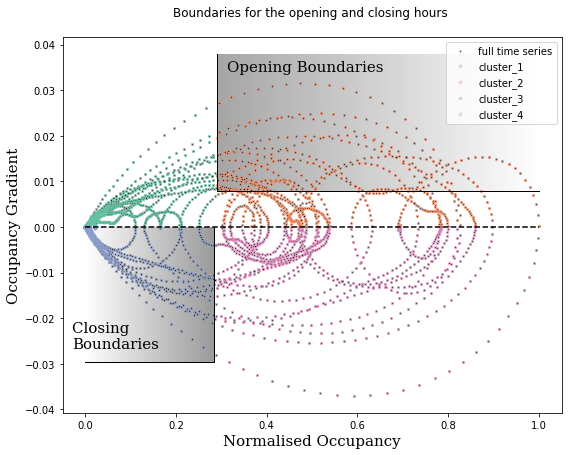

In [9]:
kmeans = [kmeans_open, kmeans_close]

fig, axs = plt.subplots(figsize = (8, 6))
axs.plot(df_var['n_people'], df_var['dn_people'], 'k.', alpha = 0.5, ms = 2, label = 'full time series')
axs.plot(df_var['n_people'][df_var['dn_people'] >= 0.].values[kmeans[0].labels_ == [0]], df_var['dn_people'].values[df_var['dn_people'] >= 0.][kmeans[0].labels_ == [0]],
         'o', mec = '#66c2a5', mfc = 'None', label = 'cluster_1', ms = 2.7, mew = 0.5)
axs.plot(df_var['n_people'][df_var['dn_people'] >= 0.].values[kmeans[0].labels_ == [1]], df_var['dn_people'].values[df_var['dn_people'] >= 0.][kmeans[0].labels_ == [1]],
         'o', mec = '#fc8d62', mfc = 'None', label = 'cluster_2', ms = 2.7, mew = 0.5)
axs.plot(df_var['n_people'][df_var['dn_people'] <= 0.].values[kmeans[1].labels_ == [0]], df_var['dn_people'].values[df_var['dn_people'] <= 0.][kmeans[1].labels_ == [0]],
         'o', mec = '#8da0cb', mfc = 'None', label = 'cluster_3', ms = 2.7, mew = 0.5)
axs.plot(df_var['n_people'][df_var['dn_people'] <= 0.].values[kmeans[1].labels_ == [1]], df_var['dn_people'].values[df_var['dn_people'] <= 0.][kmeans[1].labels_ == [1]],
         'o', mec = '#e78ac3', mfc = 'None', label = 'cluster_4', ms = 2.7, mew = 0.5)

# Draw the opening boundaries
alpha_dim = np.linspace(0.8, 0., 1000)
upper_bound = df_var['dn_people'].values.max() * 1.2
for alpha_i, bar_i in enumerate(np.linspace(opening_bounds[0], 1.0, 1000)):
    dl = np.diff(np.linspace(opening_bounds[0], 1.0, 1000))[0]
    axs.fill_between([bar_i, bar_i+dl], [opening_bounds[1], opening_bounds[1]], [upper_bound, upper_bound],
                     color = '#8f8f8f', alpha = alpha_dim[alpha_i], lw = 0.0)
axs.text(opening_bounds[0] + 0.03*(1.0 - opening_bounds[0]),
         opening_bounds[1] + 0.88*(upper_bound - opening_bounds[1]), 
         'Opening Boundaries', fontproperties = font0)
axs.plot([opening_bounds[0], 1.0], [opening_bounds[1], opening_bounds[1]], 'k-', lw = 1)
axs.plot([opening_bounds[0], opening_bounds[0]], [opening_bounds[1], upper_bound], 'k-', lw = 1)

# Draw the closing boundaries
alpha_dim = np.linspace(0., 0.9, 1000)
lower_bound = df_var['dn_people'].values.min() * 0.8
for alpha_i, bar_i in enumerate(np.linspace(0.0, closing_bounds[0], 1000)):
    dl = np.diff(np.linspace(0.0, closing_bounds[0], 1000))[0]
    axs.fill_between([bar_i, bar_i+dl], [closing_bounds[1], closing_bounds[1]], [lower_bound, lower_bound],
                     color = '#8f8f8f', alpha = alpha_dim[alpha_i], lw = 0.0)
axs.text(lower_bound + 0.1*(closing_bounds[1] - 0.),
         lower_bound + 0.1*(closing_bounds[1] - lower_bound), 
         'Closing \nBoundaries', fontproperties = font0)
axs.plot([0., closing_bounds[0]], [lower_bound, lower_bound], 'k-', lw = 1)
axs.plot([closing_bounds[0], closing_bounds[0]], [lower_bound, closing_bounds[1]], 'k-', lw = 1)

axs.plot([0., 1.], [0., 0.], 'k--')

axs.set_xlabel('Normalised Occupancy', fontproperties = font0)
axs.set_ylabel('Occupancy Gradient', fontproperties = font0)
axs.legend()
plt.tight_layout()
plt.title('Boundaries for the opening and closing hours \n')
plt.show()

The figure above shows the same as before, but with the 4 clusters as well as the critical values to which the shop is believed to be opening or closing shown. We can now walk along the time series, calculating the smoothed normalised occupancy and its rate of change, and if the shop is close at time t and that at time t+1 the opening boundaries are crossed, we can flag this time as the opening hour and set the status of the shop as open. When the closing boundaries are then crossed, the status of the shop is changed to close.

This can be done for each of the days of the week to get the opening hours. The opening time can also be updated across several weeks using a weighted average of the current opening times with any potential new collected data.

### Opening hours of the shop

In this section we show the opening hours of this particular shop. To do this, we use the full 15 days and the boundaries in occupancy and its gradient defined in the previous section. Because we have three Mondays and two of each of the other days, we use a weighted average of each of these individual daily time series. The results are dumped into a JSON file, and if more data were to be taken for this shop, one can add the new opening hours to the existing ones (weighted average), and update them using the same boundaries.

In [10]:
import os
import json

day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define the status of the shop for the full time series
status = ['close' for i in range(0, len(df_var))]
closed = True
for i in range(0, len(df_var)):
    if (df_var['dn_people'].values[i] > opening_bounds[1]) & (df_var['n_people'].values[i] > opening_bounds[0]):
        if closed == True:
            closed = False
    if (df_var['dn_people'].values[i] < opening_bounds[1]) & (df_var['n_people'].values[i] < closing_bounds[0]):
        if closed == False:
            closed = True
    if closed == False:
        status[i] = 'open'

# add the status and the dates into the df
df_var['status'] = status
dates = [datetime.datetime.fromtimestamp(timestamp_unix_i).date() for timestamp_unix_i in df_var['timestamp_unix'].values]
df_var['date'] = dates
print(df_var.info())

# Wrap it per days of the week
t_s = df_var.copy()
file_name = 'shop_test'
dates_unique = np.unique(dates)
day_vec = np.arange(0., 24., 0.5)
for date in dates_unique:

    df_day = t_s[t_s['date'] == date]
    day = datetime.datetime.fromtimestamp(df_day['timestamp_unix'].values[0]).weekday()

    hour = [datetime.datetime.fromtimestamp(timestamp_unix_i).hour for timestamp_unix_i in df_day['timestamp_unix'].values]
    minute = [datetime.datetime.fromtimestamp(timestamp_unix_i).minute for timestamp_unix_i in df_day['timestamp_unix'].values]
    second = [datetime.datetime.fromtimestamp(timestamp_unix_i).second for timestamp_unix_i in df_day['timestamp_unix'].values]
    hour_frac = np.array(hour) + np.array(minute)/60. + np.array(second)/1200.

    open_prob = np.zeros(len(df_day))
    open_prob[df_day['status'].values == 'open'] = 1.

    open_prob_interp = np.interp(day_vec, hour_frac, open_prob)

    if os.path.exists('./tmp/opening_hours_'+file_name+'.json'):
        with open('./tmp/opening_hours_'+file_name+'.json') as json_file:
            open_hour_dict = json.load(json_file)

        if day_of_week[day] in open_hour_dict.keys():
            hours_updated = np.array(open_hour_dict[day_of_week[day]]) + open_prob_interp
            open_hour_dict[day_of_week[day]] = (hours_updated/np.array([hours_updated.max(), 0.01]).max()).tolist()
        else:
            open_hour_dict[day_of_week[day]] = open_prob_interp.tolist()

    else:
        open_hour_dict = {'hours_day': day_vec.tolist(), day_of_week[day]:open_prob_interp.tolist()}

    with open('./tmp/opening_hours_'+file_name+'.json', 'w') as outfile:
        json.dump(open_hour_dict, outfile)
  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4318 entries, 0 to 4317
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp_unix  4318 non-null   float64
 1   n_people        4318 non-null   float64
 2   dn_people       4318 non-null   float64
 3   status          4318 non-null   object 
 4   date            4318 non-null   object 
dtypes: float64(3), object(2)
memory usage: 168.8+ KB
None


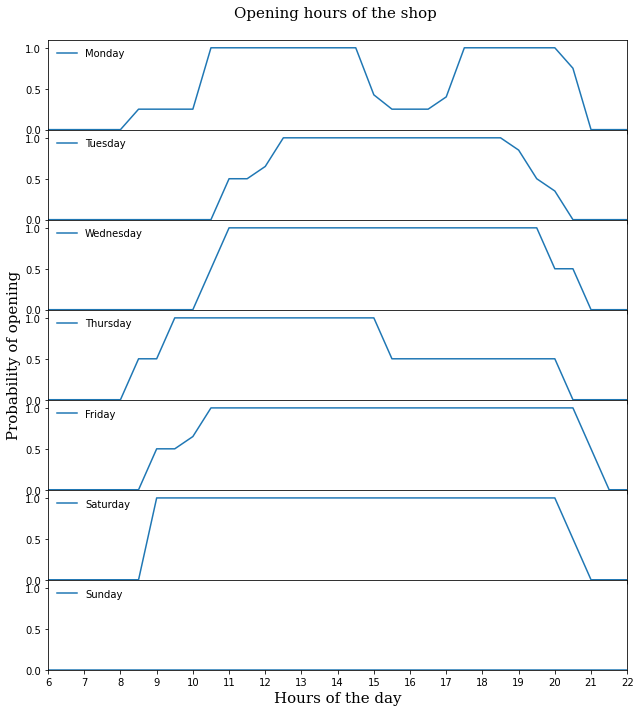

In [11]:
path_file = './tmp/opening_hours_shop_test.json'
with open(path_file, 'r') as f:
    df_open = json.load(f)

fig, axs = plt.subplots(7, 1, figsize = (9, 10), sharey = True, sharex = True)
ax = axs.ravel()
min_hour = 0.
for i, day_i in enumerate(day_of_week):

    ax[i].plot(df_open['hours_day'], df_open[day_i], label = day_i)
    ax[i].legend(frameon = False, loc = 'upper left')
    ax[i].locator_params(axis="x", nbins=24)
    ax[i].locator_params(axis="y", nbins=4)

axs[-1].set_xlabel('Hours of the day', fontproperties = font0)
axs[3].set_ylabel('Probability of opening', fontproperties = font0)
axs[0].set_ylim([0., 1.1])

axs[0].set_title('Opening hours of the shop \n', fontproperties = font0)
axs[0].set_xlim([6., 22.])
plt.tight_layout()
fig.subplots_adjust(hspace = 0.0, wspace=0.)
plt.show()

This figure shows the opening hours of our test shop with 30 mins uncertainties, where each panel corresponds to a day of the week. When the probability is not zero or one, it means that from one week to an other, there is some disagreements between the distribution of occupancy and its gradient. For instance, Monday the shop is clearly open by 10am, but it is not clear wether is it open between 8am and 9am. In addition, it is not clear whether the shop remains open throughout the day, or whether it closes between 2-to-5 pm on Monday. Adding more data would perfect and precise these opening hours and create sharper and more deterministic opening hours distributions.

## Conclusion

In this exercise, I show how we can use a simple Kmean clustering to extract opening hours of shops using data of pinged phones. To do this, we used time series of 2 weeks and model the occupancy and its rate of change to separate the staff to the customers. The opening hours are calculated using boundaries within this parameter space, and cannot be defined in a deterministic way, and instead probablity of opening hours are given depending on the length of the time series. More incoming data will help fine tuning the clusters as well as the opening hours.

Further work could also involve exploring a different parameter space to attempt a better separation between the staff and the customer. For instance, the phones have a unique ID, and staff are expected to spend more time in the shop than a classic customer. Therefore, in theory, the ID of the phone could be used to further separate staff and customer, helping having more deterministic opening times for our shopping centre.